## ПРОЕКТ: УДЕРЖАНИЕ АКТИВНОСТИ ПОСТОЯННЫХ ПОКУПАТЕЛЕЙ

### ОПИСАНИЕ ПРОЕКТА

Заказчик проекта - интернет-магазин "В один клик". Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться.\
Выход - удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

### ЗАДАЧА ПРОЕКТА

Задача проекта - разработка модели, которая предскажет вероятность снижения покупательской активности.

### ПЛАН ПРОЕКТА

1. [Загрузка и изучение данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Объединение таблиц](#4)
5. [Корреляционных анализ](#5)
6. [Использование пайплайнов](#6)
7. [Анализ важности признаков](#7)
8. [Сегментация покупателей](#8)
9. [Общий вывод](#9)

<a id="1"></a>
# Загрузка и изучение данных

## Получение данных из файлов, запись в датафреймы

In [1]:
!pip install jupyter_black -q

In [2]:
!pip install shap -q

In [3]:
!pip install phik -q

In [4]:
!pip install -Uq scikit-learn

Импортируем необходимые библиотеки

In [5]:
# импорт pandas и необходимых библиотек
import jupyter_black
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import phik
import seaborn as sns
import shap


import warnings

from joblib import dump, load
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

jupyter_black.load()

RANDOM_STATE = 42

Откроем файлы, прочтем и запишем в переменные.

In [6]:
# объявление переменных
market_file = "market_dataset.csv"
market_money = "market_money_dataset.csv"
market_time = "time_dataset.csv"
money = "money_dataset.csv"
user_path = "..."
general_path = "..."


# функция для чтения файлов
def get_read_file(general_path, user_path, file, delimiter, decimal):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(path1, sep=delimiter, decimal=decimal)
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(path2, sep=delimiter, decimal=decimal)
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную main_df
main_df = get_read_file(general_path, user_path, market_file, ",", ".")
main_df.name = "main_df"
# чтение csv-файла в датафрейм с сохранением в переменную market_money_df
market_money_df = get_read_file(general_path, user_path, market_money, ",", ".")
market_money_df.name = "market_money_df"
# чтение csv-файла в датафрейм с сохранением в переменную market_time_df
market_time_df = get_read_file(general_path, user_path, market_time, ",", ".")
market_time_df.name = "market_time_df"
# чтение csv-файла в датафрейм с сохранением в переменную money_df
money_df = get_read_file(general_path, user_path, money, ";", ",")
money_df.name = "money_df"

## Изучение данных

Изучим общую информацию о полученных датафреймах

In [9]:
# объявление списка датафреймов
df_lst = [main_df, market_money_df, market_time_df, money_df]


# функции для вывода информации о датафреймах
def get_method(method):
    return [getattr(df, method) for df in df_lst]


def get_info(df_lst, get_method, flag=True):
    i = 0
    for df in df_lst:
        print(f"Датафрейм - {df.name}")
        print("---------")
        if flag:
            display(get_method[i]())
        else:
            get_method[i]()
        print("")
        i += 1


# вывод первых 5-ти строчек датафреймов
get_info(df_lst, get_method("head"))

Датафрейм - main_df
---------


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



Датафрейм - market_money_df
---------


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



Датафрейм - market_time_df
---------


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Датафрейм - money_df
---------


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [10]:
# вывод основной информации о датафреймах
get_info(df_lst, get_method("info"), flag=False)

Датафрейм - main_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  

Обратим внимание на наименования столбцов в датафреймах

In [11]:
# вывод наименований столбцов в датафреймах
for df in df_lst:
    print("")
    print(f"Датафрейм - {df.name}")
    print("---------")
    print(*df.columns.tolist(), sep="\n")


Датафрейм - main_df
---------
id
Покупательская активность
Тип сервиса
Разрешить сообщать
Маркет_актив_6_мес
Маркет_актив_тек_мес
Длительность
Акционные_покупки
Популярная_категория
Средний_просмотр_категорий_за_визит
Неоплаченные_продукты_штук_квартал
Ошибка_сервиса
Страниц_за_визит

Датафрейм - market_money_df
---------
id
Период
Выручка

Датафрейм - market_time_df
---------
id
Период
минут

Датафрейм - money_df
---------
id
Прибыль


Переименуем столбцы:
 - приведём наименования столбцов к нижнему регистру
 - слова соединим нижним подчёркиванием

In [12]:
# функция для переименования столбцов в датафреймах
def rename_columns(df):
    lst_columns = df.columns.to_list()
    new_lst_columns = []
    for col in lst_columns:
        col = col.lower()
        col = col.replace(" ", "_")
        new_lst_columns.append(col)
    df.columns = new_lst_columns


# переименование столбцов
for df in df_lst:
    rename_columns(df)
# проверка переименования
get_info(df_lst, get_method("info"))

Датафрейм - main_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  

None


Датафрейм - market_money_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


Датафрейм - market_time_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


Датафрейм - money_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

***

**ВЫВОД:**

1. Данные загружены в датафреймы
2. Наименования столбцов во всех датафреймах были приведены к единому виду.

<a id='2'></a>
# Предобработка данных

## Предобработка пропусков и явных дубликатов

Выведем количество явных дубликатов

In [13]:
# вывод количества явных дубликатов датафреймов
for df in df_lst:
    print(df.name, end=" - ")
    print(df.duplicated().sum())

main_df - 0
market_money_df - 0
market_time_df - 0
money_df - 0


Проверим данные на пропущенные значения

In [14]:
# вывод количества пропущенных значений
for df in df_lst:
    print(df.name, end=" - ")
    print(df.isna().sum().sum())

main_df - 0
market_money_df - 0
market_time_df - 0
money_df - 0


## Предобработка типов данных

Обратим внимание на типы данных в таблице

In [15]:
# вывод типов данных в столбцах в датафреймах
for df in df_lst:
    print("")
    print(f"Датафрейм - {df.name}")
    print("---------")
    print(df.dtypes)


Датафрейм - main_df
---------
id                                       int64
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object

Датафрейм - market_money_df
---------
id           int64
период      object
выручка    float64
dtype: object

Датафрейм - market_time_df
---------
id         int64
период    object
минут      int64
dtype: object

Датафрейм - money_df
---------
id           int64
прибыль    float64
dtype: object


Тип данных в столбцах `'маркет_актив_6_мес'` и `'акционные_покупки'` датафрейма **main_df**,\
а также тип данных в столбце `'выручка'` датафрейма **market_money_df**\
не соответствуют данным: среднемесячные значения и выручка должны быть типа ***float***, а не ***object***

Преобразуем тип данных

In [16]:
# изменение типа данных в столбцах
main_df[["маркет_актив_6_мес", "акционные_покупки"]] = main_df[
    ["маркет_актив_6_мес", "акционные_покупки"]
].astype(float)
market_money_df["выручка"] = market_money_df["выручка"].astype(float)

## Предобработка неявных дубликатов

Проверим данные на наличие неявных дубликатов.\
Выведем значения в колонках со строковым типом данных для датафрейма **main_df**

In [17]:
# объявление функции для вывода значений столбцов со строковым типом данных
def get_str_values(df):
    obj_lst = df.select_dtypes(exclude="number").columns.to_list()
    print(df.name)
    print("---------")
    for col in obj_lst:
        print("---------")
        print(df[col].value_counts())


# вызов функции для датафрейма main_df
get_str_values(main_df)

main_df
---------
---------
покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64
---------
тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64
---------
разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64
---------
популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64


Выведем значения в колонках со строковым типом данных для датафрейма **market_money_df**

In [18]:
# вызов функции для датафрейма market_money_df
get_str_values(market_money_df)

market_money_df
---------
---------
период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64


In [19]:
# вызов функции для датафрейма market_time_df
get_str_values(market_time_df)

market_time_df
---------
---------
период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64


В датафрейме **main_df** в столбце `'тип_сервиса'` присутствуют значения "стандартт" и "стандарт" - неявные дубликаты\
В датафрейме **market_time_df** в столбце `'период'` присутствует значение "предыдцщий_месяц" - явная описка\
В датафрейме **main_df** в столбце `'популярная_категория'` присутствует значение "Косметика и аксесуары" - орфографическая ошибка

Исправим значения.

In [20]:
# замена значений в столбце
main_df["тип_сервиса"] = main_df["тип_сервиса"].replace("стандартт", "стандарт")
market_time_df["период"] = market_time_df["период"].replace(
    "предыдцщий_месяц", "предыдущий_месяц"
)
main_df["популярная_категория"] = main_df["популярная_категория"].replace(
    "Косметика и аксесуары", "Косметика и аксессуары"
)

Так как ID покупателей - это уникальные значения, зафиксируем их как индексы датафрейма **main_df**.

In [21]:
# установление индексов в датафрейме
main_df.set_index("id", drop=True, inplace=True)

Проверим, сколько уникальных значений ID покупателей есть в датафрейме **market_money_df**

In [22]:
# вывод количества уникальных значений id
market_money_df["id"].nunique()

1300

Количество уникальных значений совпадает с количеством в датафрейме **main_df**.\
Установим ID как индекс и развернём таблицу так, чтобы записи по каждому ID покупателя были в одну строку.

In [23]:
# установление индексов в датафрейме
market_money_df.set_index("id", drop=True, inplace=True)

# поворот таблицы
market_money_df = market_money_df.pivot_table(index="id", columns="период")

# присвоение столбцам названий без мультииндекса
market_money_df.columns = ["_".join(x) for x in market_money_df.columns]

In [24]:
# проверка преобразований
market_money_df.head()

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


Проверим, сколько уникальных значений ID покупателей есть в датафрейме **market_time_df**

In [25]:
# вывод количества уникальных значений id
market_time_df["id"].nunique()

1300

Количество уникальных значений совпадает с количеством в датафрейме **main_df**.\
Установим ID как индекс и развернём таблицу так, чтобы записи по каждому ID покупателя были в одну строку.

In [26]:
# установление индексов в датафрейме
market_time_df.set_index("id", drop=True, inplace=True)

# поворот таблицы
market_time_df = market_time_df.pivot_table(index="id", columns="период")

# присвоение столбцам названий без мультииндекса
market_time_df.columns = ["_".join(x) for x in market_time_df.columns]

In [27]:
# проверка преобразований
market_time_df.head()

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215348,13.0,14.0
215349,12.0,10.0
215350,8.0,13.0
215351,11.0,13.0
215352,8.0,11.0


Проверим, сколько уникальных значений ID покупателей есть в датафрейме **money_df**

In [28]:
# вывод количества уникальных значений id
money_df["id"].nunique()

1300

Количество уникальных значений совпадает с количеством в датафрейме **main_df**.\
Установим ID как индекс и развернём таблицу так, чтобы записи по каждому ID покупателя были в одну строку.

In [29]:
# установление индексов в датафрейме
money_df.set_index("id", drop=True, inplace=True)

In [30]:
# проверка преобразований
money_df.head()

,прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


***

**ВЫВОД:**

1. Явные дубликаты в датафреймах отсутствуют.
2. Пропущенных значений в датафреймах нет.
3. Тип данных в столбцах `'маркет_актив_6_мес'` и `'акционные_покупки'` датафрейма **main_df**,\
    а также тип данных в столбце `'выручка'` датафрейма **market_money_df** приведены к типу ***float***
4. В датафрейме **main_df**  в столбце `'тип_сервиса'` обнаружены и исправлены неявные дубликаты значений
5. В датафреймах **main_df** (столбец `'популярная_категория'`) и **market_time_df** (столбец `'период'`)\
    обнаружены и исправлены ошибки в написании значений
6. Во всех датафреймах были установлены ID покупателей как индексы.
7. В датафреймах **market_money_df**, **market_time_df** и **money_df** был выполнен разворот с тем,\
    чтобы данные по одному покупателю располагались в одной строке.

<a id='3'></a>
# Исследовательский анализ данных

## Анализ признаков датафрейма **main_df**

### Анализ количественных признаков датафрейма **main_df**

Проведём статистический анализ признаков в датафрейме **main_df**

Выведем описательную статистику для количественных признаков датафрейма

In [31]:
# создание списка количественных признаков
main_num_lst = main_df.select_dtypes(include=["number"]).columns.to_list()

# создание списка категориальных признаков
main_cat_lst = main_df.select_dtypes(exclude=["number"]).columns.to_list()

# вывод описательной статистики для количественных признаков датасета
main_df[[*main_num_lst]].describe().round(3)

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000,1300.000,1300.000,1300.00,1300.000,1300.000,1300.000,1300.000
mean,4.254,4.012,601.898,0.32,3.270,2.840,4.185,8.177
std,1.015,0.697,249.856,0.25,1.355,1.971,1.955,3.978
min,0.900,3.000,110.000,0.00,1.000,0.000,0.000,1.000
25%,3.700,4.000,405.500,0.17,2.000,1.000,3.000,5.000
50%,4.200,4.000,606.000,0.24,3.000,3.000,4.000,8.000
75%,4.900,4.000,806.000,0.30,4.000,4.000,6.000,11.000
max,6.600,5.000,1079.000,0.99,6.000,10.000,9.000,20.000


Для признаков `'маркет_актив_6_мес'`, `'страниц_за_визит'` и `'маркет_актив_тек_мес'` средние значения отличаются от медианных не существенно,\
хотя стандартные отклонения по признакам `'маркет_актив_6_мес'` (1,015) и `'страниц_за_визит'` (3.978) достаточно большие.\
В признаке `'длительность'` заметен большой разброс значений (от 110 до 1079)

Для большей наглядности построим диаграммы размаха для количественных признаков датасета.

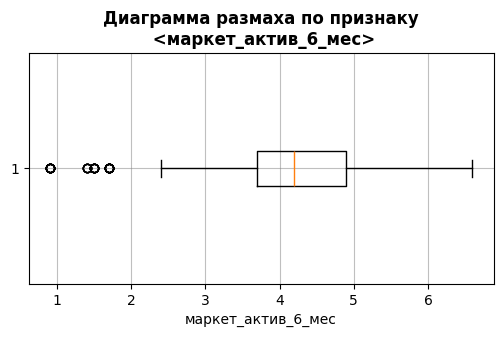

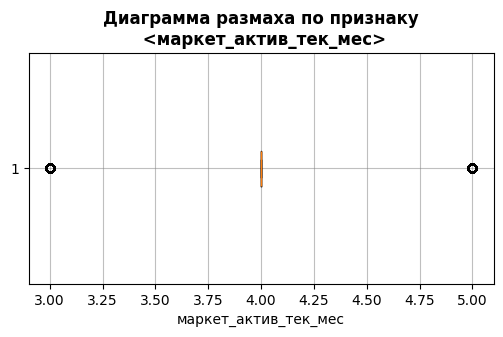

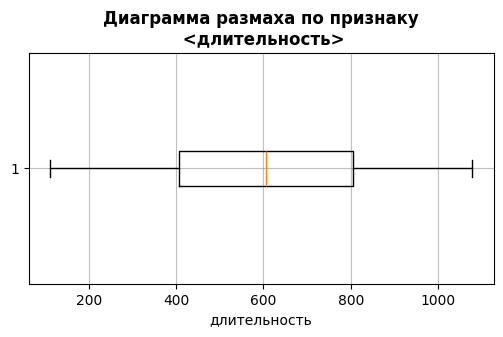

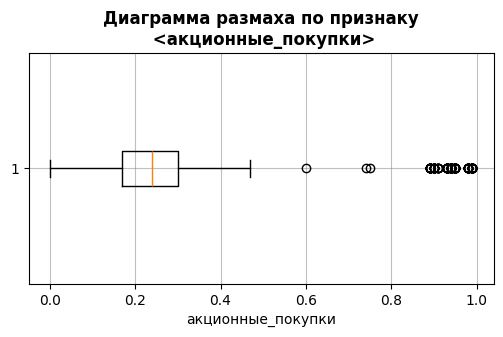

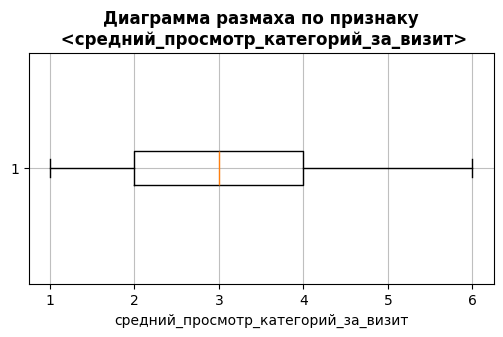

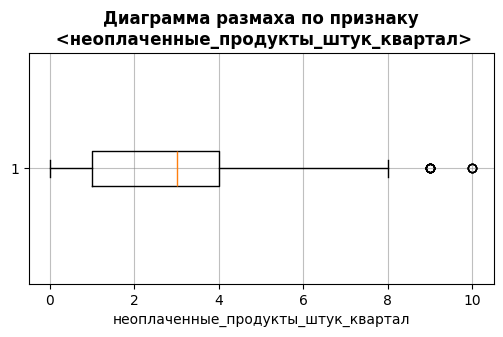

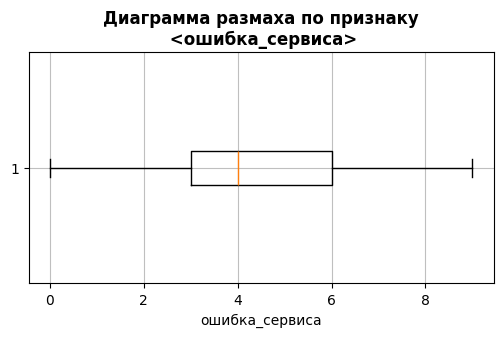

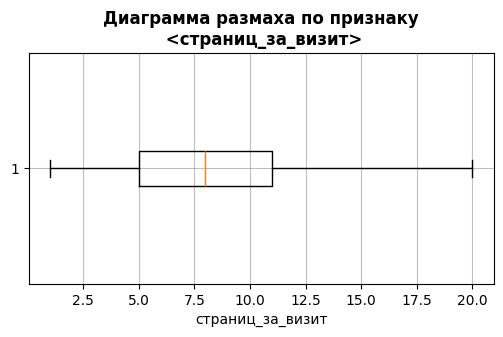

In [32]:
# функция для построения диаграммы размаха
def get_boxplot(df, item):
    plt.rcParams["figure.figsize"] = (
        6,
        3,
    )  # установка параметров графика: размер фигуры

    plt.boxplot(df[item], vert=False)
    plt.title(
        f"Диаграмма размаха по признаку\n <{item}>",
        weight="bold",
    )
    plt.xlabel(f"{item}")
    plt.grid(color="grey", axis="both", alpha=0.5)
    plt.show()


# построение графиков
def set_plot(df, item_lst, plot):
    for item in item_lst:
        plot(df, item)


# построение диаграммы размаха для количественных признаков датасета
set_plot(main_df, main_num_lst, get_boxplot)

На диаграммах размаха видно:
1. По признаку `'маркет_актив_6_мес'` - несколько выбросов ниже края статистически значимой выборки.
2. По признаку `'маркет_актив_тек_мес'` - данные сосредоточены на одном значении - 4, есть выбросы.
3. По признаку `'акционные_покупки'` - большое количество выбросов выше края статистически значимой выборки.
4. По признаку `'неоплаченные_продукты_штук_квартал'` - несколько выбросов выше значения верхней границы.
5. По признакам `'длительность'`, `'средний_просмотр_категорий_за_визит'`, `'ошибка_сервиса'`, `'страниц_за_визит'`\
    выбросы отсутствуют.

Для количественных признаков датафрейма **main_df** построим гистограммы распределения

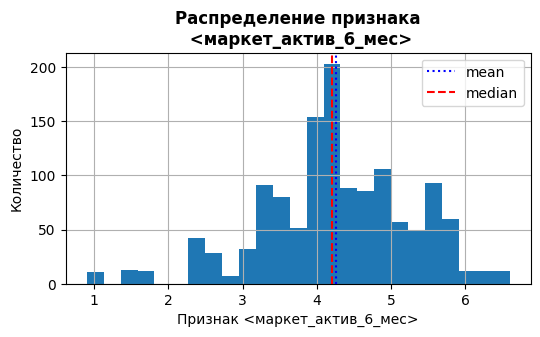

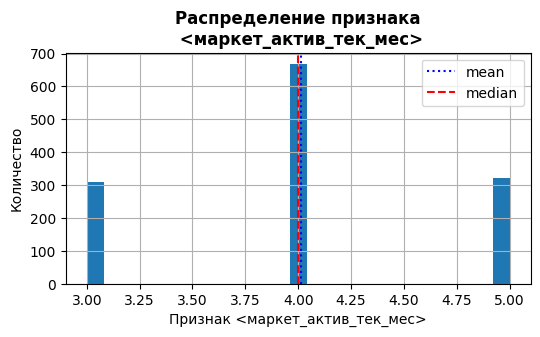

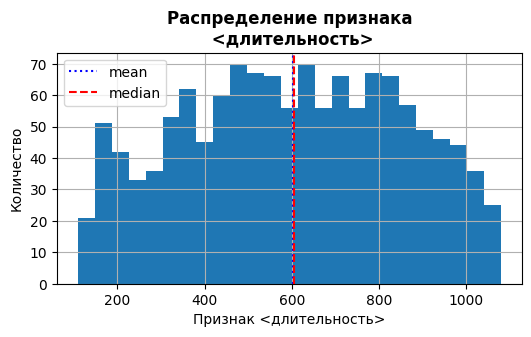

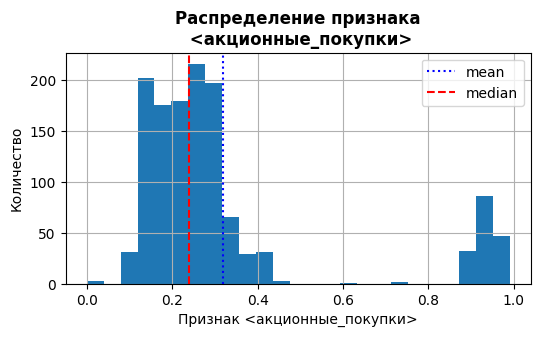

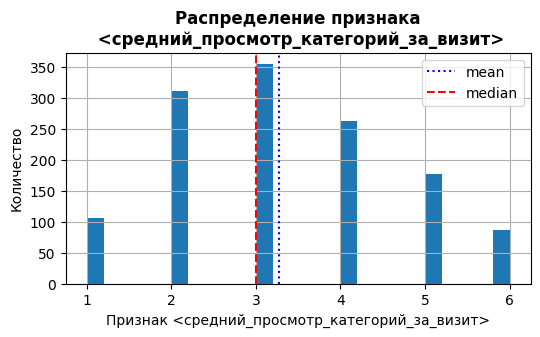

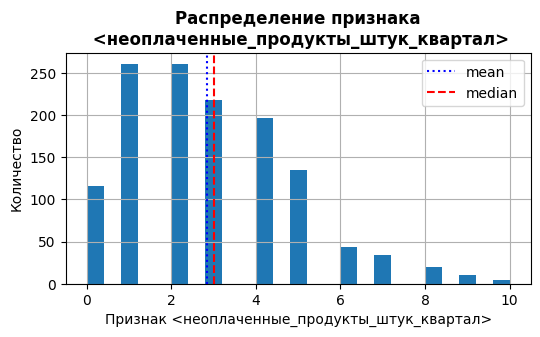

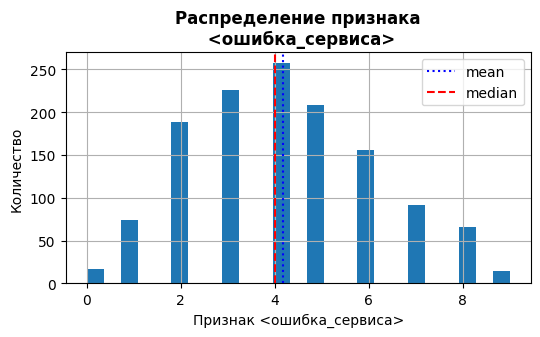

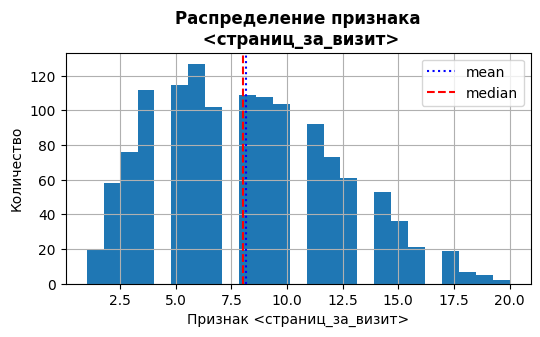

In [33]:
# функция для построения гистограммы
def get_hist(df, item):
    mean_value = df[item].mean()
    median_value = df[item].median()
    df[item].hist(bins=25)
    plt.title(f"Распределение признака\n <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество")
    plt.axvline(x=mean_value, label="mean", color="b", linestyle=":")
    plt.axvline(x=median_value, label="median", color="r", linestyle="--")
    plt.legend()
    plt.show()


# построение гистограммы
set_plot(main_df, main_num_lst, get_hist)

На диаграммах распределения видно:
1. по признаку `'маркет_актив_6_мес'` распределение мультимодальное со смещением, стремится к нормальному.
2. по признаку `'маркет_актив_тек_мес'` распределение кластерное по трём значениям: 3, 4 и 5.
3. по признаку `'длительность'` распределение мультимодальное, стремится к нормальному.
4. по признаку `'акционные_покупки'` основная масса значений распределилась в два кластера.
5. по признаку `'средний_просмотр_категорий_за_визит'` распределение нормальное со смещением.
6. по признаку `'неоплаченные_продукты_штук_квартал'` распределение смещенное.
7. по признаку `'ошибка_сервиса'` распределение нормальное.
8. по признаку `'страниц_за_визит'` распределение нормальное со смещением.

### Анализ категориальных признаков датафрейма **mane_df**

Выведем описательную статистику для категориальных признаков датасета

In [34]:
# вывод описательной статистики для категориальных признаков датасета
main_df[[*main_cat_lst]].describe().round(3)

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1300,1300,1300,1300
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,924,962,330


По признакам `'покупательская_активность'`, `'тип_сервиса'` и `'разрешить_сообщать'` - по 2 значения.\
У признака `'популярная_категория'` - 6 значений.

Для категориальных признаков датасета построим столбчатые диаграммы

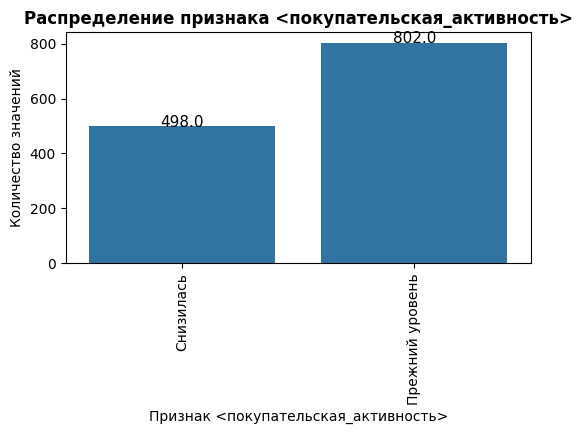

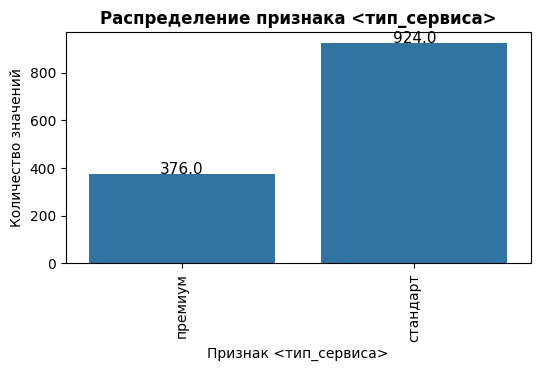

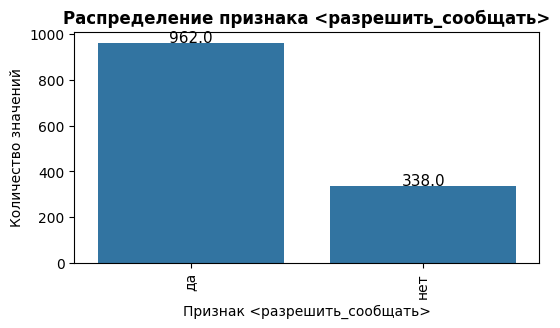

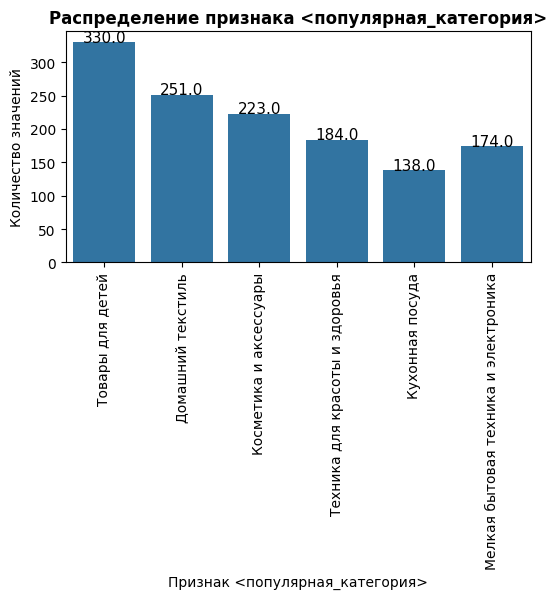

In [35]:
# функция для построения столбчатой диаграммы
def get_countplot(df, item):
    countplt, ax = plt.subplots()
    sns.countplot(x=item, data=df)
    plt.title(f"Распределение признака <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество значений")
    for rect in ax.patches:
        (
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 0.75,
                rect.get_height(),
                horizontalalignment="center",
                fontsize=11,
            )
        )
        plt.xticks(rotation="vertical")
    plt.show()


# построение столбчатой диаграммы
set_plot(main_df, main_cat_lst, get_countplot)

По признакам `'покупательская_активность'`, `'тип_сервиса'` и `'разрешить_сообщать'` наблюдается дисбаланс в классах значений.

## Анализ признаков датафрейма **market_money_df**

Проведём статистический анализ признаков в датафрейме **market_money_df**

Выведем описательную статистику датафрейма

In [36]:
# вывод описательной статистики датасета
market_money_df.describe().round(3)

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
count,1300.000,1300.000,1300.000
mean,4936.920,4825.207,5314.961
std,739.598,405.980,2939.708
min,0.000,0.000,2758.700
25%,4496.750,4583.000,4706.050
50%,5005.000,4809.000,5179.950
75%,5405.625,5053.500,5761.725
max,6869.500,5663.000,106862.200


По всем признакам - большие стандартные отклонения, особенно по признаку `'выручка_текущий_месяц'`

Для большей наглядности построим диаграммы размаха для признаков датасета.

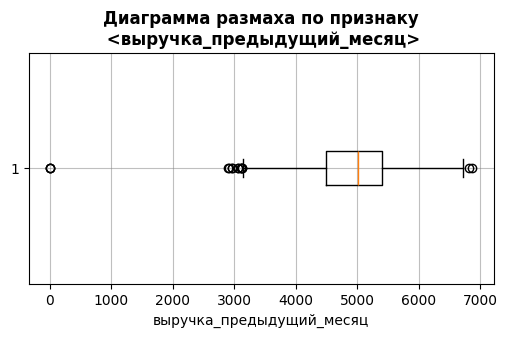

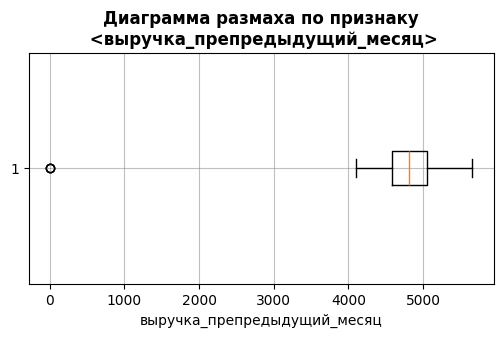

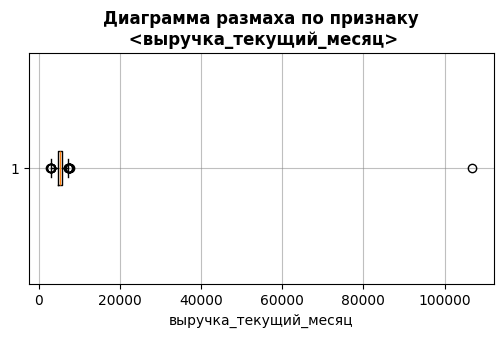

In [37]:
# построение диаграммы размаха для признаков датасета
set_plot(market_money_df, market_money_df.columns.to_list(), get_boxplot)

На диаграммах размаха:
1. по признаку `'выручка_предыдущий_месяц'` - выбросы и ниже, и выше края статистически значимой выборки,\
    присутствует нулевое значение.
3. по признаку `'выручка_препредыдущий_месяц'` - выброс со значением 0.
4. по признаку `'выручка_текущий_месяц'` - выбросы и ниже, и выше края статистически значимой выборки,\
    присутствует выброс со значением выше 100000.

Для признаков датафрейма **market_money_df** построим гистограммы распределения

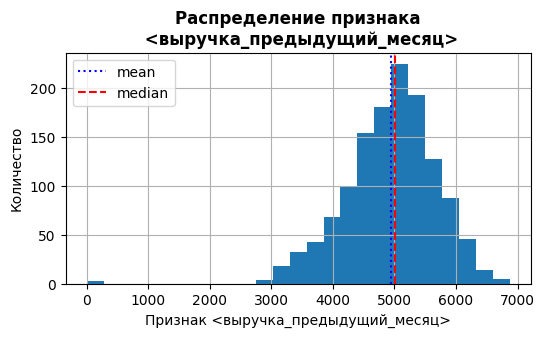

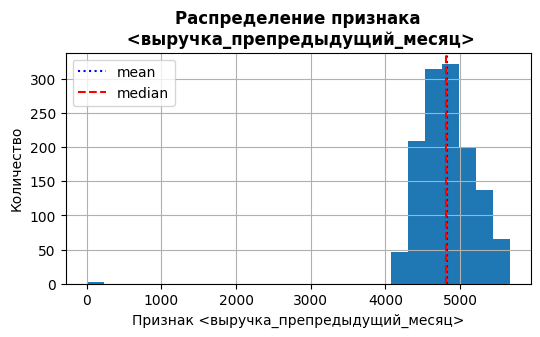

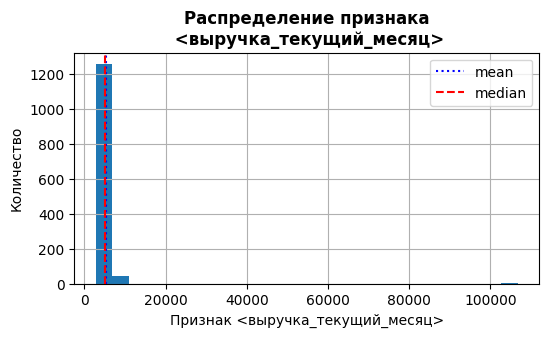

In [38]:
# построение гистограммы
set_plot(market_money_df, market_money_df.columns.to_list(), get_hist)

На диаграммах распределения:
1. по признаку `'выручка_предыдущий_месяц'` - распределение нормальное,\
    присутствует выброс с нулевым значением.
3. по признаку `'выручка_препредыдущий_месяц'` - распределение нормальное,\
    выброс со значением 0.
4. по признаку `'выручка_текущий_месяц'` - присутствует выброс со значением выше 100000.

## Анализ признаков датафрейма **market_time_df**

Проведём статистический анализ признаков в датафрейме **market_time_df**

Выведем описательную статистику датафрейма

In [39]:
# вывод описательной статистики датасета
market_time_df.describe().round(3)

,минут_предыдущий_месяц,минут_текущий_месяц
count,1300.000,1300.000
mean,13.468,13.205
std,3.932,4.221
min,5.000,4.000
25%,11.000,10.000
50%,13.000,13.000
75%,17.000,16.000
max,23.000,23.000


Среднее и медиана по обоим признакам близки по значению.

Для большей наглядности построим диаграммы размаха для признаков датафрейма.

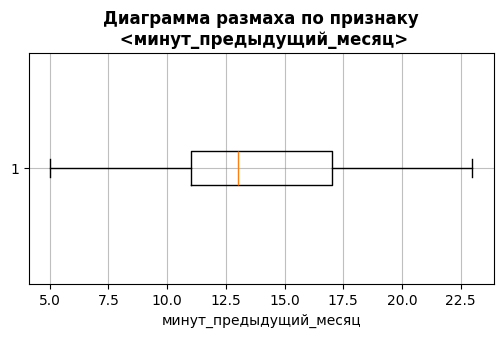

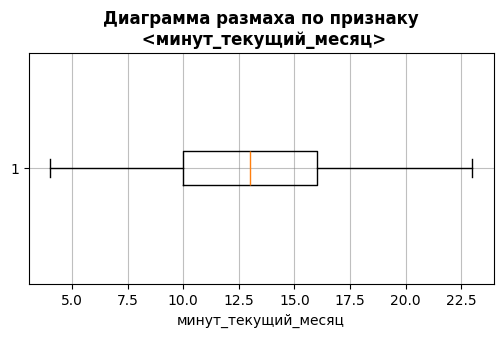

In [40]:
# построение диаграммы размаха для признаков датасета
set_plot(market_time_df, market_time_df.columns.to_list(), get_boxplot)

На диаграммах размаха по обоим признакам выбросов не наблюдается.

Для признаков датафрейма **market_time_df** построим гистограммы распределения

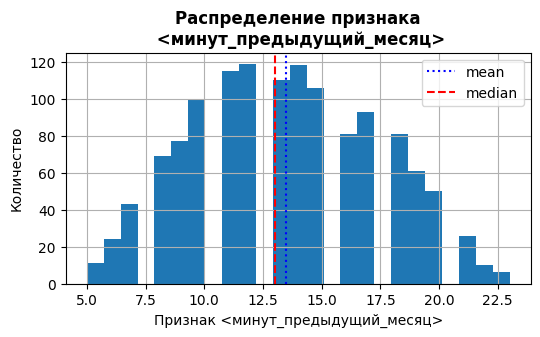

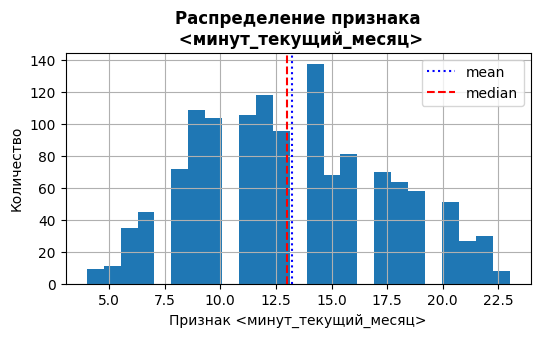

In [41]:
# построение гистограммы
set_plot(market_time_df, market_time_df.columns.to_list(), get_hist)

На диаграммах рапределения по обоим признакам наблюдается мультимодальное распределение со стремлением к нормальному.

## Анализ признаков датафрейма **money_df**

Проведём статистический анализ признаков в датафрейме **money_df**

Выведем описательную статистику датафрейма

In [42]:
# вывод описательной статистики датасета
money_df.describe().round(3)

,прибыль
count,1300.000
mean,3.997
std,1.014
min,0.860
25%,3.300
50%,4.045
75%,4.670
max,7.430


Среднее (3,997) и медиана (4,045) имеют близкие значения, хотя стандартное отклонение существенно (1,014).

Для большей наглядности построим диаграммы размаха для признаков датафрейма.

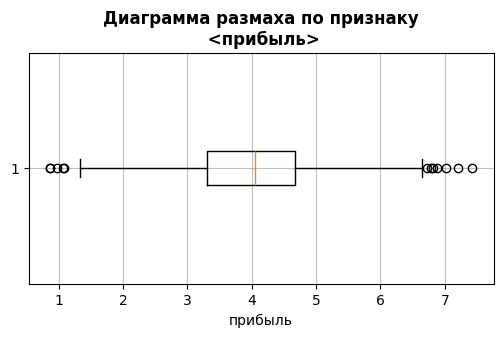

In [43]:
# построение диаграммы размаха для признаков датасета
set_plot(money_df, money_df.columns.to_list(), get_boxplot)

Наблюдаются выбросы и ниже, и выше края статистически значимой выборки.

Для признаков датафрейма **money_df** построим гистограммы распределения

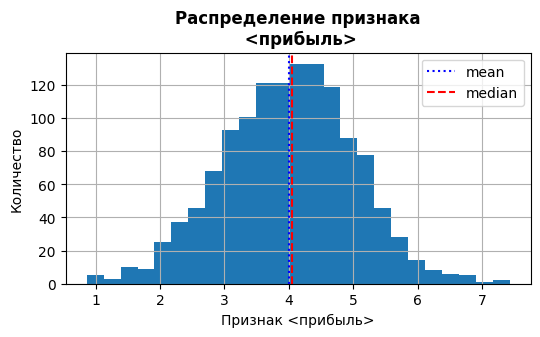

In [44]:
# построение гистограммы
set_plot(money_df, money_df.columns.to_list(), get_hist)

Диаграмма имеет нормальное распределение.

## Отбор клиентов с покупательской активностью не менее 3-х месяцев

Отберём клиентов, которые что-либо покупали в каждом из последних 3-х месяцев

In [45]:
# запись в датафрейм по условию
market_money_df = market_money_df[
    (market_money_df["выручка_предыдущий_месяц"] != 0)
    & (market_money_df["выручка_препредыдущий_месяц"] != 0)
    & (market_money_df["выручка_текущий_месяц"] != 0)
]

Для дальнейшей работы с датафреймом удалим запись с выбросом в признаке `'выручка_текущий_месяц'`

In [46]:
# удаление записи по условию
market_money_df = market_money_df[market_money_df["выручка_текущий_месяц"] < 100000]

***

**ВЫВОД:**

**датафрейм** ***main_df***
 - по количественным признакам:
1. Для признаков `'маркет_актив_6_мес'`, `'страниц_за_визит'` и `'маркет_актив_тек_мес'` средние значения отличаются от медианных не существенно,\
    хотя стандартные отклонения по признакам `'маркет_актив_6_мес'` (1,015) и `'страниц_за_визит'` (3.978) достаточно большие.\
    В признаке `'длительность'` заметен большой разброс значений (от 110 до 1079)
2. На диаграммах размаха видно:
    1. По признаку `'маркет_актив_6_мес'` - несколько выбросов ниже края статистически значимой выборки.
    2. По признаку `'маркет_актив_тек_мес'` - данные сосредоточены на одном значении - 4, есть выбросы.
    3. По признаку `'акционные_покупки'` - большое количество выбросов выше края статистически значимой выборки.
    4. По признаку `'неоплаченные_продукты_штук_квартал'` - несколько выбросов выше значения верхней границы.
    5. По признакам `'длительность'`, `'средний_просмотр_категорий_за_визит'`, `'ошибка_сервиса'`, `'страниц_за_визит'`\
    выбросы отсутствуют.
3. На диаграммах распределения видно:
    1. по признаку `'маркет_актив_6_мес'` распределение мультимодальное со смещением, стремится к нормальному.
    2. по признаку `'маркет_актив_тек_мес'` распределение кластерное по трём значениям: 3, 4 и 5.
    3. по признаку `'длительность'` распределение мультимодальное, стремится к нормальному.
    4. по признаку `'акционные_покупки'` основная масса значений распределилась в два кластера.
    5. по признаку `'средний_просмотр_категорий_за_визит'` распределение нормальное со смещением.
    6. по признаку `'неоплаченные_продукты_штук_квартал'` распределение смещенное.
    7. по признаку `'ошибка_сервиса'` распределение нормальное.
    8. по признаку `'страниц_за_визит'` распределение нормальное со смещением.
       
  - по категориальным признакам:
4. По признакам `'покупательская_активность'`, `'тип_сервиса'` и `'разрешить_сообщать'` - по 2 значения.\
   У признака `'популярная_категория'` - 6 значений.
5. По признакам `'покупательская_активность'`, `'тип_сервиса'` и `'разрешить_сообщать'` наблюдается дисбаланс в классах значений.

**датафрейм** ***market_money_df***
1. По всем признакам - большие стандартные отклонения, особенно по признаку 'выручка_текущий_месяц'
2. На диаграммах размаха:
    1. по признаку `'выручка_предыдущий_месяц'` - выбросы и ниже, и выше края статистически значимой выборки,\
        присутствует нулевое значение.
    2. по признаку `'выручка_препредыдущий_месяц'` - выброс со значением 0.
    3. по признаку `'выручка_текущий_месяц'` - выбросы и ниже, и выше края статистически значимой выборки,\
        присутствует выброс со значением выше 100000.
3. На диаграммах распределения:
    1. по признаку `'выручка_предыдущий_месяц'` - распределение нормальное,\
        присутствует выброс с нулевым значением.
    2. по признаку `'выручка_препредыдущий_месяц'` - распределение нормальное,\
        выброс со значением 0.
    3. по признаку `'выручка_текущий_месяц'` - присутствует выброс со значением выше 100000.
4. В датафрейме была удалена запись с выбросом в признаке `'выручка_текущий_месяц'`
5. В датафрейме были отобраны клиенты с покупательской активностью не менее 3-х месяцев.

**датафрейм** ***market_time_df***
1. Среднее и медиана по обоим признакам близки по значению.
2. На диаграммах размаха по обоим признакам выбросов не наблюдается.
3. На диаграммах рапределения по обоим признакам наблюдается мультимодальное распределение со стремлением к нормальному.

**датафрейм** ***money_df***
1. Среднее (3,997) и медиана (4,045) имеют близкие значения, хотя стандартное отклонение существенно (1,014).
2. Наблюдаются выбросы и ниже, и выше каря статистически значимой выборки.
3. Диаграмма имеет нормальное распределение.

<a id='4'></a>
# Объединение таблиц

Объединим таблицы методом ***merge***

In [47]:
# объединение таблиц
main_df = main_df.merge(market_time_df, on="id", how="left")
main_df = main_df.merge(market_money_df, on="id", how="right")

In [48]:
# проверка объединения
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит            

***

**ВЫВОД:**

1. Проведено объединение таблиц методом ***merge*** по **id**

<a id='5'></a>
# Корреляционный анализ

Построим матрицу корреляции Фи, которая работает как с количественными, так и с категориальными признаками.

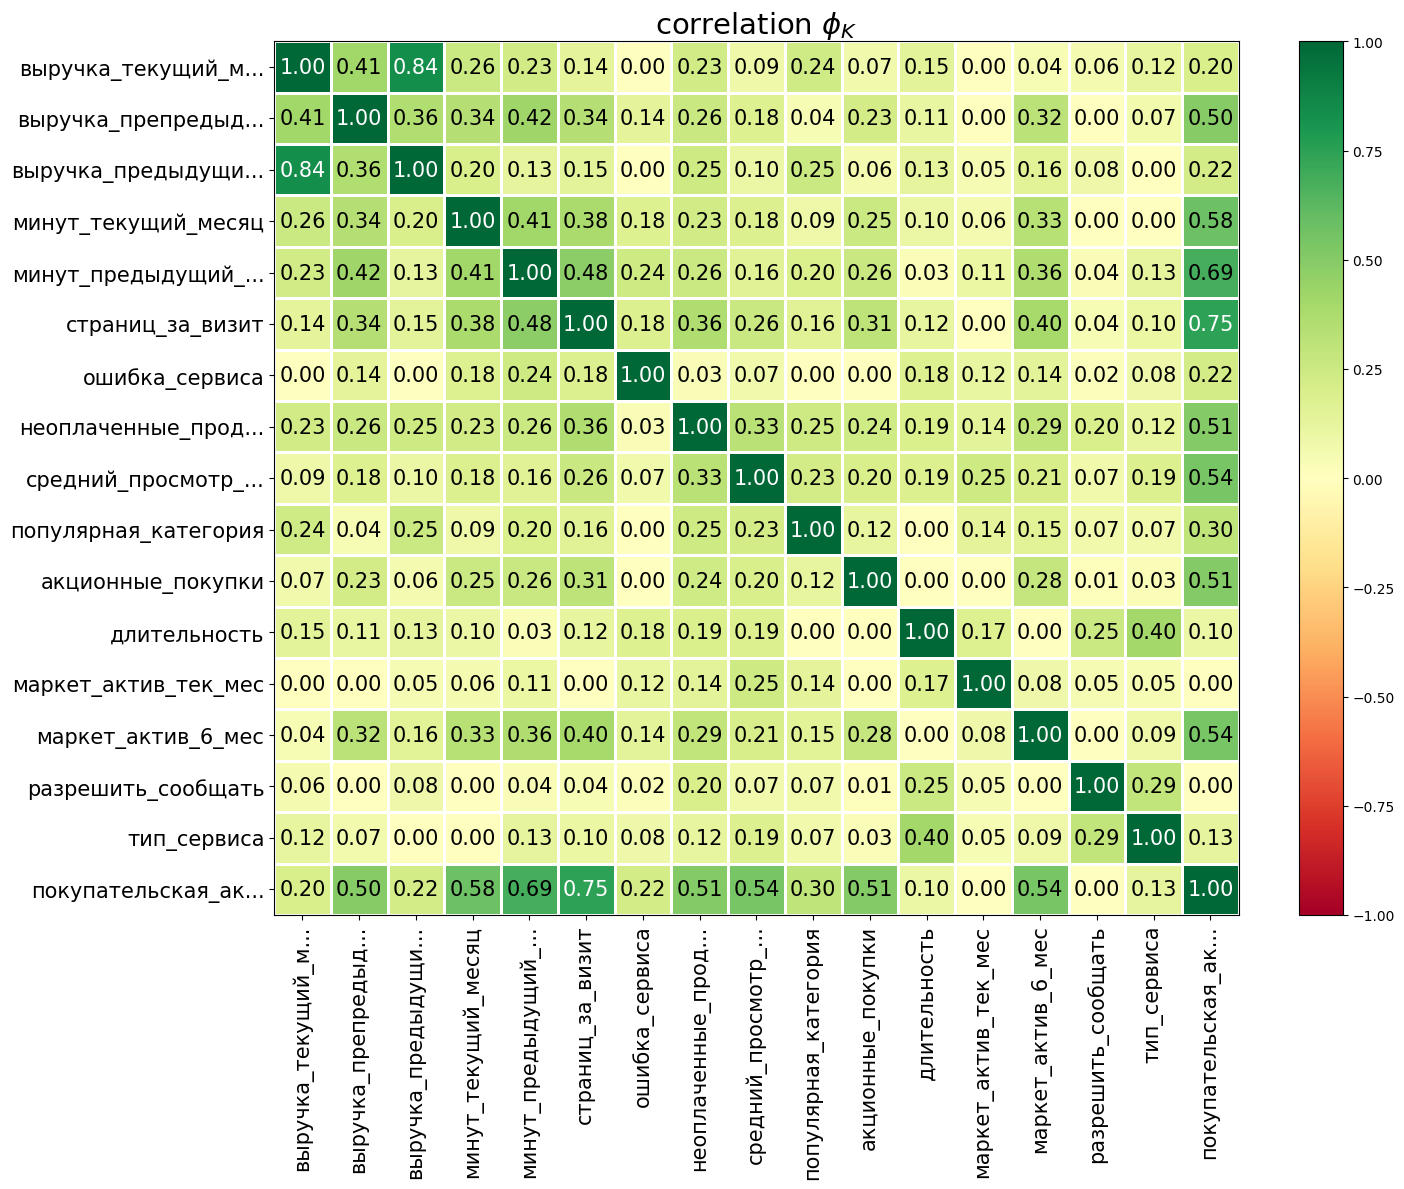

In [49]:
# объявление списка количественных признаков
main_num_lst = main_df.select_dtypes(include=["number"]).columns.to_list()

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = main_df.phik_matrix(interval_cols=main_num_lst)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12),
)

***

**ВЫВОД:**
1. Согласно шкале Чеддока между целевым признаком `'покупательская_активность'` и входными признаками выявлена линейная связь.\
   Теснота связи по корреляции Фи:
    - с входным признаком `'страниц_за_визит'` - высокая
    - с входным признаком `'маркет_актив_6_мес'` - заметная
    - с входным признаком `'акционные_покупки'` - заметная
    - с входным признаком `'средний_просмотр_категорий_за_визит'` - заметная
    - с входным признаком `'неоплаченные_продукты_штук_квартал'` - заметная
    - с входным признаком `'минут_предыдущий_месяц'` - заметная
    - с входным признаком `'минут_текущий_месяц	'` - заметная
    - с входным признаком `'выручка_препредыдущий_месяц'` - умеренная
    - с входным признаком `'тип_сервиса'` - слабая
    - с входным признаком `'длительность'` - слабая
    - с входным признаком `'популярная_категория'` - слабая
    - с входным признаком `'ошибка_сервиса'` - слабая
    - с входным признаком `'выручка_предыдущий_месяц'` - слабая
2. Мультиколлинеарность между входными признаками согласно корреляции Фи отсутствует.

<a id='6'></a>
# Использование пайплайнов

Для построения модели используем пайплайны.\
Для подготовки данных будем использовать ColumnTransformer.\
Для кодирования категориальных признаков будем использовать кодировщики:
 - OneHotEncoder()
 - OrdinalEncoder()

Для масштабирования количественных признаков будем использовать скейлеры:
 - MinMaxScaler()
 - StandardScaler()
 - RobustScaler()
 - и аргумент "passthrough" - вариант без масштабирования.

Целевой признак кодируем кодировщиком
 - LabelEncoder.

Будем обучать модели с гиперпараметрами:
 - DecisionTreeClassifier() с ***max_depth*** и ***max_features***
 - KNeighborsClassifier() с ***n_neighbors***
 - LogisticRegression() с ***С***
 - SVC() с ***С*** и ***gamma***

Для подбора лучшей модели с гиперпараметрами будем использовать
 - RandomizedSearchCV()

Для оценки качества работы модели применим метрику ROC_AUC:
- модель необходимо оценить вне зависимости от выбранного порога вероятности
- объектов с одним значением целевого признака больше, чем с другим.

In [50]:
# разделение датафрейма на целевой и входные признаки
X = main_df.drop(columns="покупательская_активность")
y = main_df["покупательская_активность"]

In [51]:
# формирование тренировочной и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

In [52]:
# создание списков с признаками
ohe_columns = ["тип_сервиса", "разрешить_сообщать"]
ord_columns = ["популярная_категория"]
num_columns = main_df.select_dtypes(include=["number"]).columns.to_list()

In [53]:
# кодирование целевого признака
y_label = LabelEncoder()
y_train_label = y_label.fit_transform(y_train)
y_test_label = y_label.transform(y_test)

In [54]:
# создание pipeline для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            "simpleImputer_ohe",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "ohe",
            OneHotEncoder(drop="first", sparse_output=False),
        ),
    ]
)

In [55]:
# создание pipeline для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
            "simpleImputer_before_ord",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        (
            "ord",
            OrdinalEncoder(
                categories=[
                    [
                        "Товары для детей",
                        "Домашний текстиль",
                        "Косметика и аксессуары",
                        "Техника для красоты и здоровья",
                        "Мелкая бытовая техника и электроника",
                        "Кухонная посуда",
                    ]
                ],
                handle_unknown="use_encoded_value",
                unknown_value=np.nan,
            ),
        ),
        (
            "simpleImputer_after_ord",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
    ]
)

In [56]:
# создание общего pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ("ohe", ohe_pipe, ohe_columns),
        ("ord", ord_pipe, ord_columns),
        ("num", MinMaxScaler(), num_columns),
    ],
    remainder="passthrough",
)

In [57]:
# создание итогового pipeline с инициализацией модели
pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]
)

In [58]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        "models": [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        "models__max_depth": range(2, 5),
        "models__max_features": range(2, 5),
        "preprocessor__ord": [OrdinalEncoder()],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели KNeighborsClassifier()
    {
        "models": [KNeighborsClassifier()],
        "models__n_neighbors": range(2, 5),
        "preprocessor__ord": [OneHotEncoder(drop="first", sparse_output=False)],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели LogisticRegression()
    {
        "models": [
            LogisticRegression(
                random_state=RANDOM_STATE,
                solver="liblinear",
                penalty="l1",
                class_weight="balanced",
            )
        ],
        "models__C": range(1, 5),
        "preprocessor__ord": [OneHotEncoder(drop="first", sparse_output=False)],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
    # словарь для модели SVC()
    {
        "models": [
            SVC(
                kernel="rbf",
                class_weight="balanced",
                probability=True,
                random_state=RANDOM_STATE,
            )
        ],
        "models__C": [0.01, 0.1, 1, 2, 5, 10],
        "models__gamma": [0.1, 1, 10, 100],
        "preprocessor__ord": [OneHotEncoder(drop="first", sparse_output=False)],
        "preprocessor__num": [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            "passthrough",
        ],
    },
]

In [59]:
# подбор лучшей модели с гиперпараметрами
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring="roc_auc",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
randomized_search.fit(X_train, y_train_label)

print("Лучшая модель и её параметры:\n\n", randomized_search.best_estimator_)
print(
    "Метрика лучшей модели на тренировочной выборке:",
    randomized_search.best_score_.round(3),
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  OneHotEncoder(drop='first',
                                                                sparse

In [62]:
y_test_pred = randomized_search.predict_proba(X_test)
print(
    f"Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_label, y_test_pred[:,1]), 3)}"
)
print(
    f"Смещение модели на тренировочной выборке: {(round((1-randomized_search.best_score_)*100), 2)}% - низкое смещение."
)
print(
    f"Разброс модели на тестовой выборке: {((randomized_search.best_score_-roc_auc_score(y_test_label, y_test_pred[:,1]))*100).round(2)}% - низкий разброс."
)

Метрика ROC-AUC на тестовой выборке: 0.917
Смещение модели на тренировочной выборке: (10, 2)% - низкое смещение.
Разброс модели на тестовой выборке: -1.63% - низкий разброс.


***

**ВЫВОД:**

1. При подборе лучшей модели был использован общий пайплайн для всех моделей\
    и инструмент подбора гиперпараметров.
2. Для оценки качества модели была использована метрика ROC_AUC
3. Лучшая модель - SVC() с гиперпараметрами C=1 и gamma=1
4. Метрика лучшей модели на тренировочной выборке составила 0,9,\
    а на тестовой - 0,917
5. Качество обучения модели достаточное:
    - смещение модели на тренировочной выборке - 9,96%
    - разброс модели на тестовой выборке - 1.63%

<a id='7'></a>
# Анализ важности признаков

Оценим общую значимость значимость признаков.\
Для этого воспользуемся обученной лучшей моделью.

In [63]:
# переформирование предсказания лучшей модели в DataFrame
pred_df = lambda x: randomized_search.best_estimator_.predict(
    pd.DataFrame(x, columns=X_train.columns)
)

In [64]:
# создаем объект explainer для модели
explainer = shap.KernelExplainer(pred_df, X_test)
shap_values = explainer.shap_values(X_test, nsamples=50)

  0%|          | 0/324 [00:00<?, ?it/s]

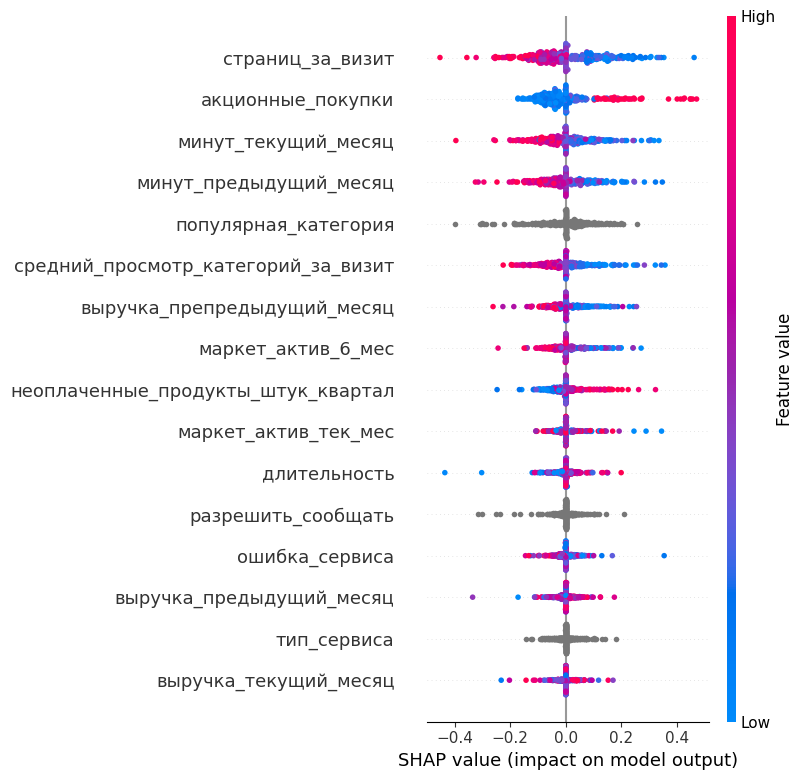

In [65]:
# график важности признаков
shap.summary_plot(shap_values, X_test)

***

**ВЫВОД:**

1. Самые важные признаки для модели:
    - ***страниц_за_визит***
    - ***акционные_покупки***
    - ***минут_предыдущий_месяц***
    - ***минут_текущий_месяц***
    - ***средний_просмотр_категорий_за_визит***
2. По признаку ***акционные_покупки*** - чем выше значение, тем более положительное влияние на целевой признак.\
    Это значит, что чем больше покупок по акции, тем выше вероятность снижения покупательской активности.
3. По признакам:
    - ***страниц_за_визит***
    - ***минут_предыдущий_месяц***
    - ***минут_текущий_месяц***
    - ***средний_просмотр_категорий_за_визит***\
    наоборот, чем выше значение, тем более отрицательный вклад,\
    тем ближе значение целевого признака к нулю - больше вероятность, что покупательская активность останется на прежнем уровне.\
    Причем вклад этих признаков примерно одинаков.
4. Мало значимые признаки:
    - ***выручка_предыдущий_месяц***
    - ***длительность***
    - ***тип_сервиса***
    - ***разрешить_сообщать***
    - ***ошибка_сервиса***
5. Наблюдения за изменениями значений важных признаков можно использовать при принятии бизнес-решений.\
    Например: при превышении определённого порога доли покупок по акции, более не предлагать акционные товары.

<a id='8'></a>
# Сегментация покупателей

## Выделение сегмента покупателей

Проведём сегментацию покупателей с использованием рузельтатов моделирования и данных о прибыльности покупателей.

Присоединим данные о прибыльности покупателей.\
Для этого сначала объединим датафреймы **main_df** и **money_df**

In [66]:
# объединение таблиц
main_money_df = main_df.merge(money_df, on="id", how="left")

Получим предсказания модели и запишем в датафрейм

In [67]:
# получение предсказания и запись в столбец датафрейма
main_money_df["предсказание"] = randomized_search.predict_proba(
    main_df.drop(columns="покупательская_активность")
)[:, 1]

Выведем описательную статистику для признака `'прибыль'`

In [68]:
main_money_df[["прибыль"]].describe()

,прибыль
count,1296.000000
mean,3.997701
std,1.011198
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


Так как магазин заинтересован в удержании более прибыльных покупателей,\
отсечём менее прибыльных покупателей,\
и для сегментации возьмём границу с первым квартилем признака (3,3),\
и отберём покупателей со значением признака выше границы.

Также определим пороговое значения для отнесения покупателей\
к группе с высокой вероятностью снижения покупательской активности.\
Так как дефолное значение порога - 0,5,\
возьмём более высокое значение - 0,7.

Определим сегмент согласно выбранным пороговым значениям.

In [69]:
# запись в датафрейм по условию
segment_df = main_money_df[
    (main_money_df["предсказание"] > 0.7) & (main_money_df["прибыль"] > 3.3)
]

Для визуализации сегмента построим диаграмму рассеяния

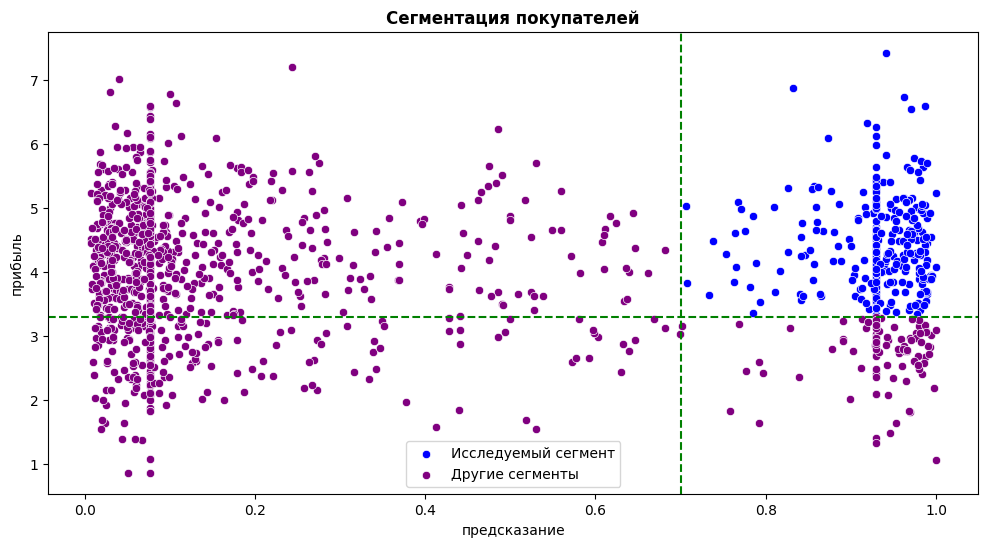

In [75]:
# построение диаграммы scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=segment_df,
    x="предсказание",
    y="прибыль",
    label="Исследуемый сегмент",
    color="blue",
)
sns.scatterplot(
    data=main_money_df[
        ~((main_money_df["предсказание"] > 0.7) & (main_money_df["прибыль"] > 3.3))
    ],
    x="предсказание",
    y="прибыль",
    label="Другие сегменты",
    color="purple",
)
plt.title("Сегментация покупателей", weight="bold")
plt.legend()
plt.axvline(x=0.7, color="green", linestyle="--")
plt.axhline(y=3.3, color="green", linestyle="--")
plt.show()

Выделим группу покупателей с максимальной долей покупок по акции.\
Для этого выделим 5 категорий признака `'акционные_покупки'`.

In [76]:
# объявление списка категорий
cut_labels_3 = ["низкий", "средний", "высокий"]
# разделение датафрейма и создание нового столбца с категориями
segment_df["доля_акционных_покупок"] = pd.cut(
    segment_df["акционные_покупки"], bins=3, labels=cut_labels_3
)

Проверим разделение

In [77]:
# подсчёт количества записей в категориях
segment_df["доля_акционных_покупок"].value_counts()

доля_акционных_покупок
низкий     214
высокий     96
средний      0
Name: count, dtype: int64

Выделим сегмент и запишем в датафрейм.

In [78]:
# выделение сегмента по условию
group_df = segment_df[segment_df["доля_акционных_покупок"] == "высокий"]

## Исследование сегмента покупателей

Обратим внимание на количественные признаки выделенного сегмента покупателей.

In [79]:
# объявление списка количественных столбцов с наиболее важными признаками
group_num_lst = group_df[
    [
        "маркет_актив_6_мес",
        "акционные_покупки",
        "средний_просмотр_категорий_за_визит",
        "неоплаченные_продукты_штук_квартал",
        "ошибка_сервиса",
        "страниц_за_визит",
        "минут_предыдущий_месяц",
        "минут_текущий_месяц",
        "выручка_препредыдущий_месяц",
        "прибыль",
    ]
].columns.to_list()

# вывод описательной статистики
group_df[[*group_num_lst]].describe()

,маркет_актив_6_мес,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_препредыдущий_месяц,прибыль
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,3.557292,0.937917,2.677083,4.041667,4.052083,4.541667,10.447917,10.416667,4635.822917,4.300417
std,1.018125,0.042918,1.200831,2.474785,1.820178,2.457713,3.018783,2.369396,276.982234,0.662583
min,0.900000,0.740000,1.000000,0.000000,1.000000,1.000000,5.000000,4.000000,4098.000000,3.320000
25%,3.000000,0.930000,2.000000,2.000000,3.000000,3.000000,8.000000,9.000000,4443.750000,3.745000
50%,3.850000,0.940000,2.500000,4.000000,4.000000,4.000000,10.000000,10.000000,4653.500000,4.265000
75%,4.100000,0.980000,3.000000,5.250000,5.000000,6.000000,12.000000,12.000000,4794.250000,4.600000
max,5.600000,0.990000,6.000000,9.000000,8.000000,14.000000,20.000000,17.000000,5612.000000,6.730000


По признакам `'маркет_актив_6_мес'`, `'средний_просмотр_категорий_за_визит'` и `'прибыль'`\
наблюдается некоторое уменьшение значений среднего и медианы в датафрейме **group_df** по сравнению с **main_df**:

|метрика|датафрейм|маркет_актив_6_мес|средний_просмотр_категорий_за_визит|
|:-|-|:-:|:-:|
|среднее|**main_df**|4.25|3.27|
|среднее|**group_df**|3.56|2.68|
|медиана|**main_df**|4.20|3.0|
|медиана|**group_df**|3.85|2.5|

По признаку `'неоплаченные_продукты_штук_квартал'` наоборот,\
некоторое повышение значений среднего (2,84 и 4,04) и медианы (3,0 и 4,0)

Существенное уменьшение значений среднего и медианы наблюдается по признакам\
`'страниц_за_визит'`, `'минут_предыдущий_месяц'` и `'минут_текущий_месяц'`\
в датафрейме **group_df** по сравнению с **main_df**:

|метрика|датафрейм|страниц_за_визит|минут_предыдущий_месяц|минут_текущий_месяц|
|:-|-|:-:|:-:|:-:|
|среднее|**main_df**|8,177|13,468|13,205|
|среднее|**group_df**|4,052|10,448|10,417|
|медиана|**main_df**|8,0|13,0|13,0|
|медиана|**group_df**|4,0|10,0|10,0|

Построим диаграммы распределения для количественных признаков сегмента

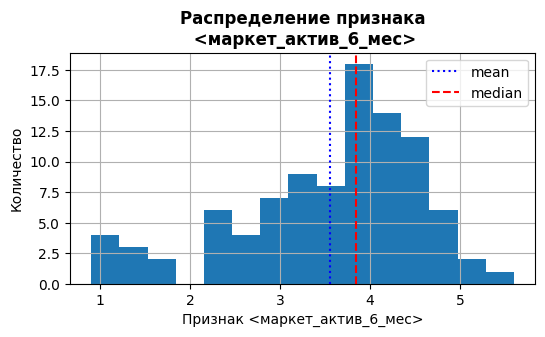

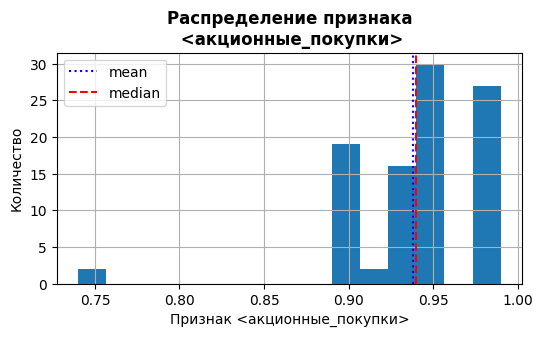

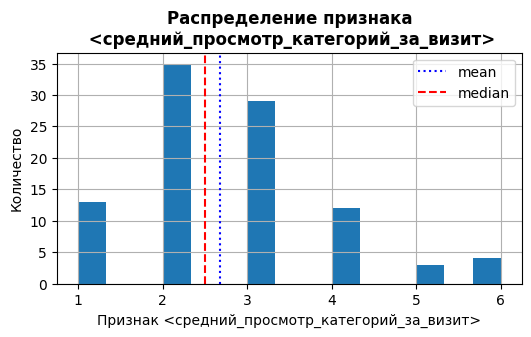

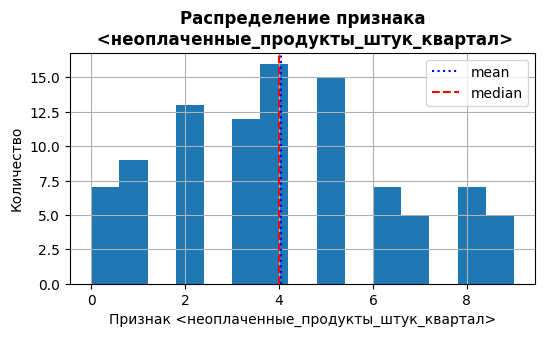

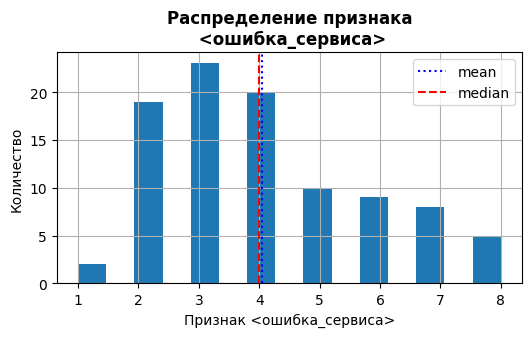

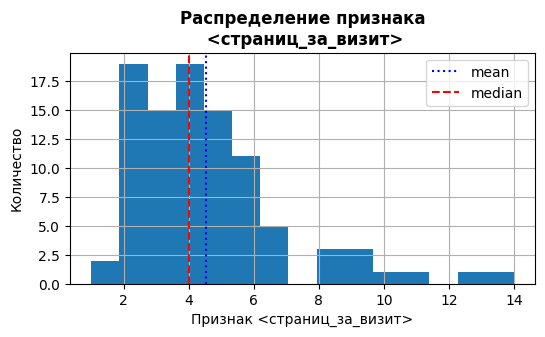

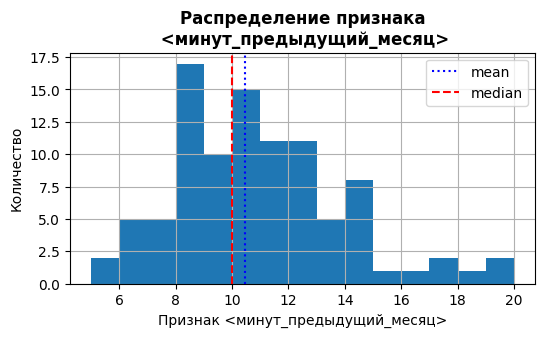

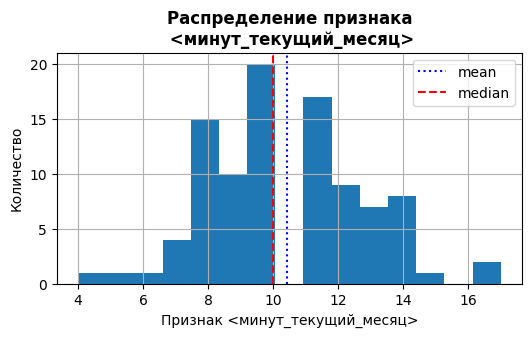

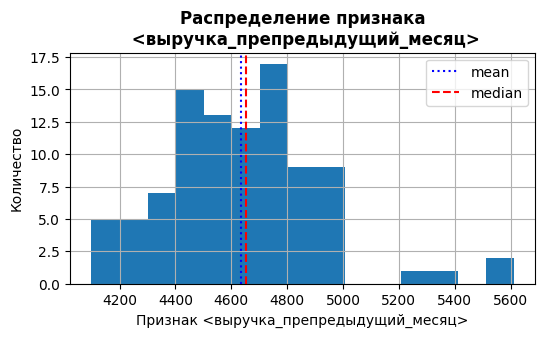

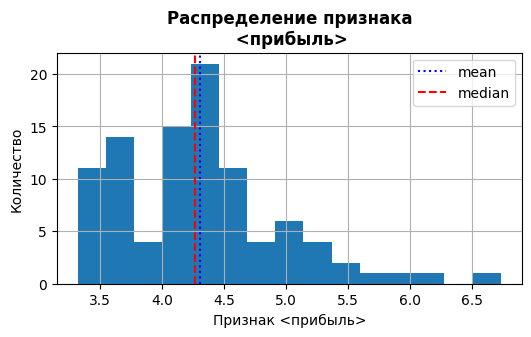

In [80]:
# построение диаграммы распределения для количественных признаков датасета
for item in group_num_lst:
    mean_value = group_df[item].mean()
    median_value = group_df[item].median()
    group_df[item].hist(bins=15)
    plt.title(f"Распределение признака\n <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество")
    plt.axvline(x=mean_value, label="mean", color="b", linestyle=":")
    plt.axvline(x=median_value, label="median", color="r", linestyle="--")
    plt.legend()
    plt.show()

На диаграммах распределения существенных отличий по распределению признаков\
между датафреймами **group_df** и **main_df** не обнаружено.

Обратим внимание на категориальные признаки выделенного сегмента покупателей

Посмотрим, как изменилось процентное отношение классов в значимых категориальных ппризнаках.

In [81]:
# вывод частоты значений классов для признака в датафреймах
print("Датафрейм group_df")
display(group_df["тип_сервиса"].value_counts(normalize=True))
print(" ")
print("Датафрейм main_df")
main_df["тип_сервиса"].value_counts(normalize=True)

Датафрейм group_df


тип_сервиса
стандарт    0.697917
премиум     0.302083
Name: proportion, dtype: float64

 
Датафрейм main_df


тип_сервиса
стандарт    0.71142
премиум     0.28858
Name: proportion, dtype: float64

In [82]:
# вывод частоты значений классов для признака в датафреймах
print("Датафрейм group_df")
display(group_df["популярная_категория"].value_counts(normalize=True))
print(" ")
print("Датафрейм main_df")
main_df["популярная_категория"].value_counts(normalize=True)

Датафрейм group_df


популярная_категория
Товары для детей                        0.375000
Домашний текстиль                       0.187500
Косметика и аксессуары                  0.177083
Кухонная посуда                         0.145833
Техника для красоты и здоровья          0.072917
Мелкая бытовая техника и электроника    0.041667
Name: proportion, dtype: float64

 
Датафрейм main_df


популярная_категория
Товары для детей                        0.253858
Домашний текстиль                       0.192901
Косметика и аксессуары                  0.172068
Техника для красоты и здоровья          0.140432
Мелкая бытовая техника и электроника    0.134259
Кухонная посуда                         0.106481
Name: proportion, dtype: float64

Наблюдаются различия между датафреймами\
как в распределении популярных категорий, так и по частоте встречаемых значений.

В целом в датафрейме **main_df** распределение встречаемых значений более однородное:\
от 10,6% менее популярной категории до 25,4% самой популярной категории.

По датафрейму **group_df** уверенный лидер в категориях - "Товары для детей" с 37,5%.

Следующие по популярности категории в процентном отношении почти не отличаются от **main_df**,\
они просто перераспределены:

|Категория|**group_df**|**main_df**|
|-|:-:|:-:|
|Косметика и аксессуары|17,7%|17,2%|
|Домашний текстиль|18,8%|19,3%|

А на категории "Техника для красоты и здоровья" и "Мелкая бытовая техника и электроника"\
приходится менее 12%.

***

**ВЫВОД:**

1. Был выделен сегмент покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательной активности.
2. Данные записаны в датафрейм **group_df**
3. По признакам `'маркет_актив_6_мес'`, `'средний_просмотр_категорий_за_визит'` и `'прибыль'`\
    наблюдается некоторое уменьшение значений среднего и медианы в датафрейме **group_df** по сравнению с **main_df**.
4. По признаку `'неоплаченные_продукты_штук_квартал'` наоборот,\
    некоторое повышение значений среднего (2,84 и 4,04) и медианы (3,0 и 4,0)
5. Существенное уменьшение значений среднего и медианы наблюдается по признакам\
    `'страниц_за_визит'`, `'минут_предыдущий_месяц'` и `'минут_текущий_месяц'`\
   в датафрейме **group_df** по сравнению с **main_df**.
6. На диаграммах распределения существенных отличий по распределению признаков\
   между датафреймами **group_df** и **main_df** не обнаружено.
7. Также наблюдаются различия между датафреймами\
   как в распределении популярных категорий, так и по частоте встречаемых значений.
8. По датафрейму **group_df** уверенный лидер в категориях - "Товары для детей" с 37,5%.
9. Вероятно, покупатели выделенного сегмента чаще всего заходят на сайт с целью купить товары для детей по акции.\
   Поэтому они тратят меньше времени на сайте, просматривают меньше категорий за визит.
10. Таких покупателей нужно заинтересовывать другими категориями.
11. Также нужно в продажах товаров для детей сместить акцент с акционных покупок на другие преимущества покупок на сайте:\
   например, сервис или качество товаров.

<a id='9'></a>
# Общий вывод

**ВХОДНЫЕ ДАННЫЕ:**
1. Исследование проведено на базе данных интернет-магазина "В один клик"
2. Данные представлены файлами:
    - market_file.csv
    - market_money.csv
    - market_time.csv
    - money_csv
3. Наименования столбцов во всех датафреймах были приведены к единому виду.



**НА ЭТАПЕ ПРЕДОБРАБОТКИ ДАННЫХ:**
1. Явные дубликаты в датафреймах отсутствуют.
2. Пропущенных значений в датафреймах нет.
3. Тип данных в столбцах `'маркет_актив_6_мес'` и `'акционные_покупки'` датафрейма **main_df**,\
    а также тип данных в столбце `'выручка'` датафрейма **market_money_df** приведены к типу ***float***
4. В датафрейме **main_df**  в столбце `'тип_сервиса'` обнаружены и исправлены неявные дубликаты значений
5. В датафреймах **main_df** (столбец `'популярная_категория'`) и **market_time_df** (столбец `'период'`)\
    обнаружены и исправлены ошибки в написании значений
6. Во всех датафреймах были установлены ID покупателей как индексы.
7. В датафреймах **market_money_df**, **market_time_df** и **money_df** был выполнен разворот с тем,\
    чтобы данные по одному покупателю располагались в одной строке.



**НА ЭТАПЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА ДАННЫХ:**

По датафреймам было выявлено:

**датафрейм** ***main_df***
 - по количественным признакам:
1. Для признаков `'маркет_актив_6_мес'`, `'страниц_за_визит'` и `'маркет_актив_тек_мес'` средние значения отличаются от медианных не существенно,\
    хотя стандартные отклонения по признакам `'маркет_актив_6_мес'` (1,015) и `'страниц_за_визит'` (3.978) достаточно большие.\
    В признаке `'длительность'` заметен большой разброс значений (от 110 до 1079)
2. На диаграммах размаха видно:
    1. По признаку `'маркет_актив_6_мес'` - несколько выбросов ниже края статистически значимой выборки.
    2. По признаку `'маркет_актив_тек_мес'` - данные сосредоточены на одном значении - 4, есть выбросы.
    3. По признаку `'акционные_покупки'` - большое количество выбросов выше края статистически значимой выборки.
    4. По признаку `'неоплаченные_продукты_штук_квартал'` - несколько выбросов выше значения верхней границы.
    5. По признакам `'длительность'`, `'средний_просмотр_категорий_за_визит'`, `'ошибка_сервиса'`, `'страниц_за_визит'`\
    выбросы отсутствуют.
3. На диаграммах распределения видно:
    1. по признаку `'маркет_актив_6_мес'` распределение мультимодальное со смещением, стремится к нормальному.
    2. по признаку `'маркет_актив_тек_мес'` распределение кластерное по трём значениям: 3, 4 и 5.
    3. по признаку `'длительность'` распределение мультимодальное, стремится к нормальному.
    4. по признаку `'акционные_покупки'` основная масса значений распределилась в два кластера.
    5. по признаку `'средний_просмотр_категорий_за_визит'` распределение нормальное со смещением.
    6. по признаку `'неоплаченные_продукты_штук_квартал'` распределение смещенное.
    7. по признаку `'ошибка_сервиса'` распределение нормальное.
    8. по признаку `'страниц_за_визит'` распределение нормальное со смещением.
       
  - по категориальным признакам:
4. По признакам `'покупательская_активность'`, `'тип_сервиса'` и `'разрешить_сообщать'` - по 2 значения.\
   У признака `'популярная_категория'` - 6 значений.
5. По признакам `'покупательская_активность'`, `'тип_сервиса'` и `'разрешить_сообщать'` наблюдается дисбаланс в классах значений.

**датафрейм** ***market_money_df***
1. По всем признакам - большие стандартные отклонения, особенно по признаку 'выручка_текущий_месяц'
2. На диаграммах размаха:
    1. по признаку `'выручка_предыдущий_месяц'` - выбросы и ниже, и выше края статистически значимой выборки,\
        присутствует нулевое значение.
    2. по признаку `'выручка_препредыдущий_месяц'` - выброс со значением 0.
    3. по признаку `'выручка_текущий_месяц'` - выбросы и ниже, и выше края статистически значимой выборки,\
        присутствует выброс со значением выше 100000.
3. На диаграммах распределения:
    1. по признаку `'выручка_предыдущий_месяц'` - распределение нормальное,\
        присутствует выброс с нулевым значением.
    2. по признаку `'выручка_препредыдущий_месяц'` - распределение нормальное,\
        выброс со значением 0.
    3. по признаку `'выручка_текущий_месяц'` - присутствует выброс со значением выше 100000.
4. В датафрейме была удалена запись с выбросом в признаке `'выручка_текущий_месяц'`
5. В датафрейме были отобраны клиенты с покупательской активностью не менее 3-х месяцев.

**датафрейм** ***market_time_df***
1. Среднее и медиана по обоим признакам близки по значению.
2. На диаграммах размаха по обоим признакам выбросов не наблюдается.
3. На диаграммах рапределения по обоим признакам наблюдается мультимодальное распределение со стремлением к нормальному.

**датафрейм** ***money_df***
1. Среднее (3,997) и медиана (4,045) имеют близкие значения, хотя стандартное отклонение существенно (1,014).
2. Наблюдаются выбросы и ниже, и выше каря статистически значимой выборки.
3. Диаграмма имеет нормальное распределение.


**НА ЭТАПЕ ОБЪЕДИНЕНИЯ ТАБЛИЦ:**
1. Проведено объединение таблиц методом ***merge*** по **id**


**НА ЭТАПЕ КОРРЕЛЯЦИОННОГО АНАЛИЗА ДАННЫХ:**
1. Согласно шкале Чеддока между целевым признаком `'покупательская_активность'` и входными признаками выявлена линейная связь.\
   Теснота связи по корреляции Фи:
    - с входным признаком `'страниц_за_визит'` - высокая
    - с входным признаком `'маркет_актив_6_мес'` - заметная
    - с входным признаком `'акционные_покупки'` - заметная
    - с входным признаком `'средний_просмотр_категорий_за_визит'` - заметная
    - с входным признаком `'неоплаченные_продукты_штук_квартал'` - заметная
    - с входным признаком `'минут_предыдущий_месяц'` - заметная
    - с входным признаком `'минут_текущий_месяц	'` - заметная
    - с входным признаком `'выручка_препредыдущий_месяц'` - умеренная
    - с входным признаком `'тип_сервиса'` - слабая
    - с входным признаком `'длительность'` - слабая
    - с входным признаком `'популярная_категория'` - слабая
    - с входным признаком `'ошибка_сервиса'` - слабая
    - с входным признаком `'выручка_предыдущий_месяц'` - слабая
2. Мультиколлинеарность между входными признаками согласно корреляции Фи отсутствует.


**НА ЭТАПЕ ИСПОЛЬЗОВАНИЯ ПАЙПЛАЙНОВ:**
1. Для построения модели были использованы пайплайны.
2. Для подготовки данных был использован ColumnTransformer.
3. Для кодирования категориальных признаков были использованы кодировщики:
    - OneHotEncoder()
    - OrdinalEncoder()
4. Для масштабирования количественных признаков были использованы скейлеры:
    - MinMaxScaler()
    - StandardScaler()
    - RobustScaler()
    - и аргумент "passthrough" - вариант без масштабирования.
5. Целевой признак был закодирован кодировщиком
    - LabelEncoder.
6. Были обучены модели с гиперпараметрами:
    - DecisionTreeClassifier() с ***max_depth*** и ***max_features***
    - KNeighborsClassifier() с ***n_neighbors***
    - LogisticRegression() с ***С***
    - SVC() с ***С*** и ***gamma***
7. Для подбора лучшей модели с гиперпараметрами был использован
    - RandomizedSearchCV()
8. При подборе лучшей модели был использован общий пайплайн для всех моделей\
    и инструмент подбора гиперпараметров.
9. Для оценки качества модели была использована метрика ROC_AUC
10. Лучшая модель - SVC() с гиперпараметрами C=1 и gamma=1
11. Метрика лучшей модели на тренировочной выборке составила 0,902,\
    а на тестовой - 0,87
12. Качество обучения модели достаточное:
    - смещение модели на тренировочной выборке - 9,77%
    - разброс модели на тестовой выборке - 3,32%


**НА ЭТАПЕ АНАЛИЗА ВАЖНОСТИ ПРИЗНАКОВ:**

1. Самые важные признаки для модели:
    - ***страниц_за_визит***
    - ***акционные_покупки***
    - ***минут_предыдущий_месяц***
    - ***минут_текущий_месяц***
    - ***средний_просмотр_категорий_за_визит***
2. По признаку ***акционные_покупки*** - чем выше значение, тем более положительное влияние на целевой признак.\
    Это значит, что чем больше покупок по акции, тем выше вероятность снижения покупательской активности.
3. По признакам:
    - ***страниц_за_визит***
    - ***минут_предыдущий_месяц***
    - ***минут_текущий_месяц***
    - ***средний_просмотр_категорий_за_визит***\
    наоборот, чем выше значение, тем более отрицательный вклад,\
    тем ближе значение целевого признака к нулю - больше вероятность, что покупательская активность останется на прежнем уровне.\
    Причем вклад этих признаков примерно одинаков.
4. Мало значимые признаки:
    - ***выручка_предыдущий_месяц***
    - ***длительность***
    - ***тип_сервиса***
    - ***разрешить_сообщать***
    - ***ошибка_сервиса***
5. Наблюдения за изменениями значений важных признаков можно использовать при принятии бизнес-решений.\
    Например: при превышении определённого порога доли покупок по акции, более не предлагать акционные товары.


**НА ЭТАПЕ СЕГМЕНТАЦИИ ПОКУПАТЕЛЕЙ:**

1. Был выделен сегмент покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательной активности по покупателям с высокой прибыльностью.
2. Данные записаны в датафрейм **group_df**
3. По признакам `'маркет_актив_6_мес'`, `'средний_просмотр_категорий_за_визит'` и `'прибыль'`\
    наблюдается некоторое уменьшение значений среднего и медианы в датафрейме **group_df** по сравнению с **main_df**.
4. По признаку `'неоплаченные_продукты_штук_квартал'` наоборот,\
    некоторое повышение значений среднего (2,84 и 4,04) и медианы (3,0 и 4,0)
5. Существенное уменьшение значений среднего и медианы наблюдается по признакам\
    `'страниц_за_визит'`, `'минут_предыдущий_месяц'` и `'минут_текущий_месяц'`\
   в датафрейме **group_df** по сравнению с **main_df**.
6. На диаграммах распределения существенных отличий по распределению признаков\
   между датафреймами **group_df** и **main_df** не обнаружено.
7. Также наблюдаются различия между датафреймами\
   как в распределении популярных категорий, так и по частоте встречаемых значений.
8. По датафрейму **group_df** уверенный лидер в категориях - "Товары для детей" с 37,5%.


**ВЫВОД:**
1. Вероятно, покупатели выделенного сегмента чаще всего заходят на сайт с целью купить товары для детей по акции.\
   Поэтому они тратят меньше времени на сайте, просматривают меньше категорий за визит.
2. Таких покупателей нужно заинтересовывать другими категориями.
3. Также нужно в продажах товаров для детей сместить акцент с акционных покупок на другие преимущества покупок на сайте:\
   например, сервис или качество товаров.